# Implement Online portfolio algorithms directly into the Gyn environment

In [5]:
import numpy as np
import pandas as pd

from stable_baselines3.common.type_aliases import GymEnv, MaybeCallback
from typing import Any, ClassVar, Dict, Iterable, List, Optional, Tuple, Type, TypeVar, Union

class BNNModel:
    def __init__(
            self, 
            env: Union[GymEnv, str],
            policy: Any, # Policy doesnt matter here
            device: str, # device doesnt matter here
            policy_kwargs: Optional[Dict[str, Any]] = None, # policy_kwargs doesnt matter here
            target_weights: List[float] = None, # If none, default to uniform weights
            k=5, 
            l=10
            ) -> None:
        
        # Super simple algorithm, we only need the environment

        assert env is not None 
        self.env = env

        self.k = k
        self.l = l

        self.min_history= k + l - 1

        # Pull out the actions space dimensions for the portfolio
        self.action_space_shape = self.env.action_space.shape
        self.portfolio_length = self.action_space_shape[0]

        # Calculate the inital weights, here we set all weights to zero to start
        # Then we put all value in the cash account

        # Note these are the first weight reprsents the cash account, which should always be 0
        self.current_weights = np.zeros(self.portfolio_length-1)   # target weights for each asset

        self.price_history = pd.DataFrame()

    def find_nn(self, H):
        """Note that nearest neighbors are calculated in a different (more efficient) way than shown
        in the article.

        param H: history
        """
        # calculate distance from current sequence to every other point
        D = H * 0
        for i in range(1, self.k + 1):
            D += (H.shift(i - 1) - H.iloc[-i]) ** 2
        D = D.sum(1).iloc[:-1]

        # sort and find nearest neighbors
        D = D.sort_values()
        return D.index[:self.l]


    def train(self) -> None:
        # This model is derministic and doesnt learn anything, it only predicts
        pass

    def learn(
        self
    ):
        # This model is derministic and doesnt learn anything, it only predicts
        pass

# TODO update this code
    def predict(self,
        observation: Union[np.ndarray, Dict[str, np.ndarray]],
        state: Optional[Tuple[np.ndarray, ...]] = None,
        episode_start: Optional[np.ndarray] = None,
        deterministic: bool = False, # TODO not needed this is always determininistic
    ) -> Tuple[np.ndarray, Optional[Tuple[np.ndarray, ...]]]:

        # TODO much of this comes from the policies class in stable baselines
        if isinstance(observation, tuple) and len(observation) == 2 and isinstance(observation[1], dict):
            raise ValueError(
                "You have passed a tuple to the predict() function instead of a Numpy array or a Dict. "
                "You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) "
                "vs `obs = vec_env.reset()` (SB3 VecEnv). "
                "See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 "
                "and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api"
            )

        # Reshape the array to remove single dimensions 
        reshaped_array = observation.reshape(len(self.env._features), self.portfolio_length - 1) 

        # TODO this code his horrible Extract the three lists
        prices = reshaped_array[0].tolist()

        new_row = pd.DataFrame([prices])

        # Add to the price history
        self.price_history = pd.concat([self.price_history, new_row], ignore_index=True)
        old_weights = self.current_weights

        # Normalize the prices
        r = {}
        for name, s in self.price_history.items():
            init_val = s.loc[s.first_valid_index()]
            r[name] = s / init_val
        X = pd.DataFrame(r)

        # Window is too short, use cash only
        if len(X) < self.min_history + 1:
            weights = self.current_weights
            action_weights = np.insert(weights, 0, 1)
            actions = action_weights.reshape(1, self.portfolio_length)
            return actions, None
        
        ixs = self.find_nn(X)

        J = X.iloc[[X.index.get_loc(i) + 1 for i in ixs]]
        
        self.current_weights = np.array(optimize_returns(J))

        assert np.isclose(self.current_weights.sum(), 1), "The array does not sum up to one."

        # Use the last portfolio as the new action (keep it the same)
        action_weights = np.insert(self.current_weights, 0, 0)
        actions = action_weights.reshape(1, self.portfolio_length)

        return actions, None

import scipy.optimize as optimize
def optimize_returns(
    prices
):
    assert prices.notnull().all().all()

    x_0 = np.ones(prices.shape[1]) / float(prices.shape[1])
    
    # Using price returns here.
    objective = lambda b: -np.sum(np.log(np.maximum(np.dot(prices - 1, b) + 1, 0.0001)))

    cons = ({"type": "eq", "fun": lambda b: 1 - sum(b)},)

   
    # problem optimization
    res = optimize.minimize(
        objective,
        x_0,
        bounds=[(0.0, 1.0)] * len(x_0),
        constraints=cons,
        method="slsqp"
    )

    if res.success:
        return res.x
    raise ValueError("Could not find an optimal value using the BCRP algorithm.")



In [6]:


MODELS = {"bnn": BNNModel}

class DRLStableAgent:
    """Implementation for DRL algorithms for portfolio optimization.

    Note:
        During testing, the agent is optimized through online learning.
        The parameters of the policy is updated repeatedly after a constant
        period of time. To disable it, set learning rate to 0.

    Attributes:
        env: Gym environment class.
    """

    def __init__(self, env):
        """Agent initialization.

        Args:
            env: Gym environment to be used in training.
        """
        self.env = env

    def get_model(
        self, model_name, device="cpu", model_kwargs=None, policy_kwargs=None
    ):
        """Setups DRL model.

        Args:
            model_name: Name of the model according to MODELS list.
            device: Device used to instantiate neural networks.
            model_kwargs: Arguments to be passed to model class.
            policy_kwargs: Arguments to be passed to policy class.

        Note:
            model_kwargs and policy_kwargs are dictionaries. The keys must be strings
            with the same names as the class arguments. Example for model_kwargs::

            { "lr": 0.01, "policy": EIIE }

        Returns:
            An instance of the model.
        """
        if model_name not in MODELS:
            raise NotImplementedError("The model requested was not implemented.")

        model = MODELS[model_name]
        model_kwargs = {} if model_kwargs is None else model_kwargs
        policy_kwargs = {} if policy_kwargs is None else policy_kwargs

        # add device settings
        model_kwargs["device"] = device
        #policy_kwargs["device"] = device

        # add policy_kwargs inside model_kwargs
        model_kwargs["policy_kwargs"] = policy_kwargs

        # TODO default to usethe MlpPolicy
        return model(env=self.env, policy="MlpPolicy", **model_kwargs)

    @staticmethod
    def train_model(model, env, episodes=1):
        """Trains portfolio optimization model.

        Args:
            model: Instance of the model.
            episoded: Number of episodes.

        Returns:
            An instance of the trained model.
        """
        max_steps = len(env._df['date'].unique())

        print("Max number of time steps in an episode: ", max_steps)

        model.learn(
            total_timesteps = max_steps * episodes # TODO fix this
        )
        return model

    @staticmethod
    def DRL_prediction(model, env, deterministic=True):
        """make a prediction and get results"""
        test_env, test_obs = env.get_sb_env()
        
        

        test_env.reset()
        max_steps = len(env._df['date'].unique())

        validation_assets = None
        validation_dates = None

        for i in range(max_steps):
           
            action, _states = model.predict(test_obs, deterministic=deterministic)
            print("HERE!!!!!!!")
            print(action)
            print(type(action))

            # Pull out the latest assets and dates
            validation_assets = env._asset_memory["final"]
            validation_dates = env._date_memory

            # account_memory = test_env.env_method(method_name="save_asset_memory")
            # actions_memory = test_env.env_method(method_name="save_action_memory")
            test_obs, rewards, dones, info = test_env.step(action)

            if dones[0]:
                print("hit end!")
                break
        
        return validation_assets, validation_dates

In [7]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.config_tickers import DOW_30_TICKER

# from finrl.agents.portfolio_optimization.architectures import EIIE

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

# import sys
# sys.path.append("../FinRL-Library")

import itertools

TEST_START_DATE = '2009-01-01'
TEST_END_DATE = '2024-10-01'

# TRAIN_START_DATE = '2010-01-01'
# TRAIN_END_DATE = '2021-10-01'
# TEST_START_DATE = '2021-10-01'
# TEST_END_DATE = '2023-03-01'
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.config_tickers import TEST_TICKER


# # TODO Drop the DOW stock
value_to_remove = "DOW"
# Create a new list without the specified string
DOW_30_TICKER = [x for x in DOW_30_TICKER if x != value_to_remove]
print(DOW_30_TICKER)

# STOCKS = [
#     "AAPL",
#     "MSFT",
#     "V",
# ]

# No time window needed for PPO
# TIME_WINDOW = 25
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# TODO try different date ranges
# TRAIN_START_DATE = '2009-01-01'
# TRAIN_END_DATE = '2018-10-01'
# TEST_START_DATE = '2018-10-01'
# TEST_END_DATE = '2021-03-01'

raw_df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = DOW_30_TICKER).fetch_data()


from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(raw_df)


from finrl.meta.env_portfolio_optimization.env_portfolio_opt_stable import PortfolioOptStableEnv

environment = PortfolioOptStableEnv(
        portfolio_norm_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close", "high", "low"],
        normalize_df=None
    )

BNN_results = {
    "date": {},
    "training": {},
    "2021": {},
    "2022": {},
    "2023": {}
}

# Training
agent_bnn = DRLStableAgent(env = environment)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment)
BNN_results["training"] = environment._terminal_asset_memory["final"]
BNN_results["date"] = environment._terminal_date_memory



['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS']


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Shape of DataFrame:  (114898, 8)


c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.39660606 0.62818164 0.68543954 ... 0.01947727 0.01808933 0.02899626]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.   0.   0.25 ... 0.75 1.   0.  ]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  X.loc[select_mask, self.columns] = self.scalers[value].transform(
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: 

HERE!!!!!!!
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0.]]
<class 'numpy.ndarray'>
HERE!!!!!!!
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

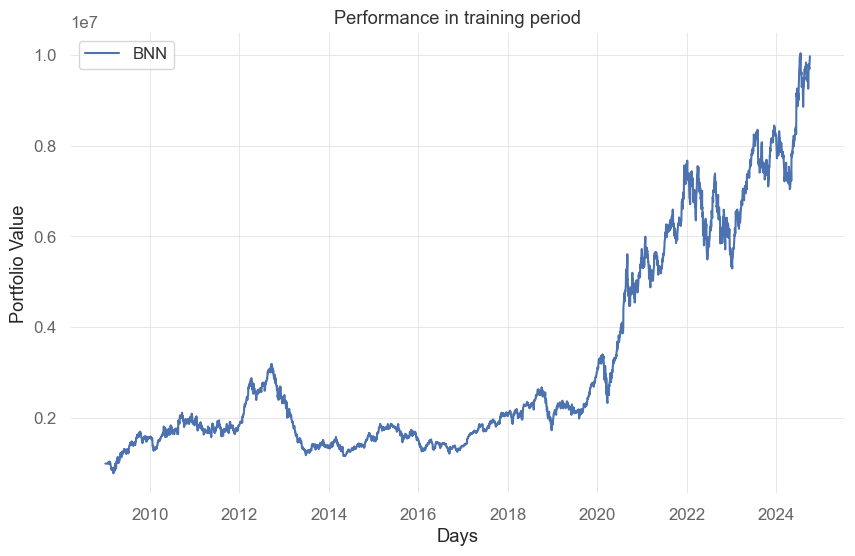

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.plot(BNN_results["date"], BNN_results["training"], label="BNN")

plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.title("Performance in training period")
plt.legend()

plt.show()